## Import

In [109]:
#import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
import numpy as np
import matplotlib.pyplot as plt

In [138]:
#import data
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
dataset = pd.concat([train,test])
dataset.head()

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,L50096,L,300.6,309.6,1596,36.1,140,0.0,0,0,0,0,0
1,1,M20343,M,302.6,312.1,1759,29.1,200,0.0,0,0,0,0,0
2,2,L49454,L,299.3,308.5,1805,26.5,25,0.0,0,0,0,0,0
3,3,L53355,L,301.0,310.9,1524,44.3,197,0.0,0,0,0,0,0
4,4,M24050,M,298.0,309.0,1641,35.4,34,0.0,0,0,0,0,0


## Data Preprocessing

### Handling duplicates

In [139]:
#DUPLICATES
train.drop_duplicates(subset=train.columns.difference(['id']),inplace=True)
test.drop_duplicates(subset=test.columns.difference(['id']), inplace=True)

### Handling missing values

In [140]:
#MISSING VALUES
train.dropna(inplace=True)
test.dropna(inplace=True)

### Encode categorical features

In [141]:
#Searching for non-ordinal categorical features
categorical_columns = train.select_dtypes(include=['object']).columns.values
#Calculating unique values of categorical features
for col in categorical_columns:
    print(f" train {col}.unique = {len(train[col].unique())}, test {col}.unique = {len(test[col].unique())}") 

 train Product ID.unique = 9976, test Product ID.unique = 9909
 train Type.unique = 3, test Type.unique = 3


Since Product Id has too many unique values we cannot use one-hot encoding for this categorical feature because that will increase the dimesion of the feature space too much, resulting in slowing down the training time. Because of that we will use one-hot encoding for the Type feature and Frequency encoding for the ProductID feature (Some suggests to use Target enconding but I think that leads to overfitting)

In [142]:
#ONE-HOT ENCODING of Type column
for df in [train, test]:
    for value in df.Type.unique():
        df[f'Type{value}'] = 0
        df.loc[df.Type == f'{value}', f'Type{value}'] = 1
    df.drop(columns=['Type'], inplace=True)

In [143]:
#Frequency ENCODING of Product ID column (It is a way to utilize the frequency of the categories as labels)
for df in [train, test]:
    df['EncodedProductID'] = df.groupby(by=['Product ID'])['Product ID'].transform('count')
    df.drop(columns=['Product ID'], inplace=True)

## Feature engineering

In [144]:
def create_features(df):
    
    # Create a new feature by subtracting 'Air temperature' from 'Process temperature'
    # df['Temperature difference [K]'] = df['Process temperature [K]'] - df['Air temperature [K]']
    
    # Create a new feature by divided 'Air temperature' from 'Process temperature'
    df["Temperature ratio"] = df['Process temperature [K]'] / df['Air temperature [K]']
    
    # Create a new feature by multiplying 'Torque' and 'Rotational speed' (POWER)
    df['Torque * Rotational speed'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    # Create a new feature by multiplying 'Torque' by 'Tool wear'
    df['Torque * Tool wear'] = df['Torque [Nm]'] * df['Tool wear [min]']

    # Create a new feature by adding 'Air temperature' and 'Process temperature'
    # df['Temperature sum [K]'] = df['Air temperature [K]'] + df['Process temperature [K]']
    
    # Create a new feature by multiplying 'Torque' by 'Rotational speed'
    df['Torque * Rotational speed'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    df['TotalFailures'] = df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].sum(axis=1)

    df.drop(['RNF'], axis =1, inplace = True)
    
    return df

In [145]:
train = create_features(train)
test = create_features(test)

## Model

In [146]:
train_X = train.drop(columns=['id', 'Machine failure']).reset_index(drop=True)
train_y = train['Machine failure'].reset_index(drop=True)
n_features = len(train_X.columns)

In [147]:
# Splitting train dataset into train and test
#train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.33)

#using the actual test set
test_X = test.drop(columns=['id']).reset_index(drop=True)

In [120]:
train_X.shape

(90647, 17)

In [148]:
# StandardScaler
sc = StandardScaler() # MinMaxScaler or StandardScaler
train_X = sc.fit_transform(train_X)
test_X = sc.fit_transform(test_X)

In [122]:
model = tf.keras.Sequential()

In [123]:

model.add(tf.keras.layers.InputLayer(input_shape=(n_features,)))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['AUC'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 32)                576       
                                                                 
 batch_normalization_19 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_20 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_31 (Dense)            (None, 128)               8320      
                                                                 
 batch_normalization_21 (Bat  (None, 128)             

In [124]:
#weighting the unbalanced target
class_weights = dict(enumerate(class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(train_y),
                                                 y=train_y)))

In [125]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=100, start_from_epoch=50, restore_best_weights=True)

In [126]:
history = model.fit(train_X, train_y, batch_size=512, epochs=1000, class_weight=class_weights, callbacks=[early_stopping], validation_split=0.25)

Epoch 1/1000


c:\Users\aless\miniconda3\envs\tf2.1-gpu\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


133/133 [==============================] - 4s 15ms/step - loss: 0.3290 - auc: 0.9220 - val_loss: 0.2807 - val_auc: 0.9506
Epoch 2/1000
133/133 [==============================] - 1s 11ms/step - loss: 0.2317 - auc: 0.9585 - val_loss: 0.1661 - val_auc: 0.9507
Epoch 3/1000
133/133 [==============================] - 1s 10ms/step - loss: 0.2187 - auc: 0.9635 - val_loss: 0.1643 - val_auc: 0.9460
Epoch 4/1000
133/133 [==============================] - 1s 10ms/step - loss: 0.2014 - auc: 0.9717 - val_loss: 0.1875 - val_auc: 0.9483
Epoch 5/1000
133/133 [==============================] - 1s 10ms/step - loss: 0.1977 - auc: 0.9723 - val_loss: 0.1432 - val_auc: 0.9477
Epoch 6/1000
133/133 [==============================] - 1s 10ms/step - loss: 0.1892 - auc: 0.9753 - val_loss: 0.1486 - val_auc: 0.9464
Epoch 7/1000
133/133 [==============================] - 1s 10ms/step - loss: 0.1860 - auc: 0.9769 - val_loss: 0.1893 - val_auc: 0.9492
Epoch 8/1000
133/133 [==============================] - 2s 11ms/step

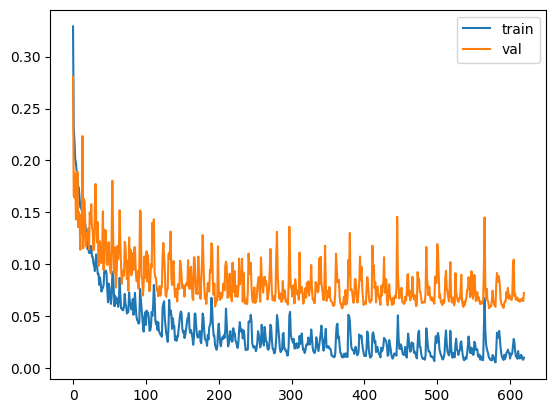

In [127]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [128]:
#predictions
# Generate Prediction
y_pred = model.predict(test_X)
from sklearn.metrics import roc_curve, roc_auc_score
roc_auc_tf = roc_auc_score(test_y, y_pred)

1396/1396 [==============================] - 2s 1ms/step


In [132]:
roc_auc_tf

0.9316523026238439

In [149]:
y_pred = model.predict(test_X)
y_pred

2826/2826 [==============================] - 4s 2ms/step


array([[2.1730191e-11],
       [1.0766472e-09],
       [4.3741724e-07],
       ...,
       [1.1883539e-08],
       [4.6856932e-11],
       [9.3769280e-08]], dtype=float32)

In [151]:
output = pd.DataFrame({
    "Machine failure" : np.squeeze(y_pred)
})
output

,Machine failure
0,2.173019e-11
1,1.076647e-09
2,4.374172e-07
3,1.799752e-10
4,1.194044e-05
...,...
90426,2.193801e-10
90427,2.566525e-11
90428,1.188354e-08
90429,4.685693e-11
